In [24]:
11

11

- EDA를 통한 모델 학습.ipynb
- 초중급반_- 2. EDA를 통한 모델 수정 1.ipynb

읽기자료 : https://ko.wikipedia.org/wiki/%EB%94%B0%EB%A6%89%EC%9D%B4

## 한글 font

In [25]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv]
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
fc-cache: invalid option -- ']'
usage: fc-cache [-EfrsvVh] [-y SYSROOT] [--error-on-no-fonts] [--force|--really-force] [--sysroot=SYSROOT] [--system-only] [--verbose] [--version] [--help] [dirs]
Build font information caches in [dirs]
(all directories in font configuration by default).

  -E, --error-on-no-fonts  raise an error if no fonts in a directory
  -f, --force              scan directories with apparently valid caches
  -r, --really-force       erase all existing caches, then rescan
  -s, --system-only        scan system-wide directories only
  -y, --sysroot=SYSROOT    prepend SYSROOT to all paths for scanning
  -v, --verbose   

## packages

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')


from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression

In [27]:
from google.colab import drive
drive.mount('/content/mydrive/')

Drive already mounted at /content/mydrive/; to attempt to forcibly remount, call drive.mount("/content/mydrive/", force_remount=True).


## csvs

In [28]:
train = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/train.csv')
train.head(1)

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
0,2018-01-01,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950


In [29]:
test = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/test.csv')
test.head(1)

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max
0,2021-01-01,NaN,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,4.1


In [30]:
# 프로젝트의 목표 : 따릉이 대여량 예측
submission = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/sample_submission.csv')
submission.head(1)

,date,rental
0,2021-01-01,0


## preprocessing for eda

In [31]:
# train set

# 전처리 1 
train['rental'] = train['rental'].astype(float)


# 전처리 2 
def extract_year_from_date(text:str):
    return int(text[:4])
train['year'] = train['date'].map(extract_year_from_date)



# 전처리 3 
def extract_month_from_date(text:str):
    return int(text[5:7])
train['month'] = train['date'].map(extract_month_from_date)


# 전처리 4
def extract_day_from_date(text:str):
    return int(text[-2:])

train['day'] = train['date'].map(extract_day_from_date)

# 전처리 5
train.dropna(axis=0, subset=['PM10', 'PM2.5'], inplace=True)

# 전처리 6, 7
imp_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
imputed_train = pd.DataFrame(imp_zero.fit_transform(train.select_dtypes(exclude=['object'])))
imputed_train.columns = ['precipitation',
                         'temp_mean',
                         'temp_highest',
                         'temp_lowest',
                         'PM10',
                         'PM2.5',
                         'humidity',
                         'sunshine_sum',
                         'sunshine_rate',
                         'wind_mean',
                         'wind_max',
                         'rental',
                         'year',
                         'month', 
                         'day']


# 전처리 8
imputed_train['year'] = imputed_train['year'].astype(int)
imputed_train['month'] = imputed_train['month'].astype(int)
imputed_train['day'] = imputed_train['day'].astype(int)

# 전처리 9
train = imputed_train

In [32]:
# test set

# 전처리 1
test['year'] = test['date'].map(extract_year_from_date)


# 전처리 2
test['month'] = test['date'].map(extract_month_from_date)


# 전처리 3
test['day'] = test['date'].map(extract_day_from_date)

# 전처리 4, 5
imputed_test = pd.DataFrame(imp_zero.fit_transform(test.select_dtypes(exclude=['object'])))
imputed_test.columns = ['precipitation',
                         'temp_mean',
                         'temp_highest',
                         'temp_lowest',
                         'PM10',
                         'PM2.5',
                         'humidity',
                         'sunshine_sum',
                         'sunshine_rate',
                         'wind_mean',
                         'wind_max',
                         'year',
                         'month', 
                         'day']


# 전처리 6
imputed_test['year'] = imputed_test['year'].astype(int)
imputed_test['month'] = imputed_test['month'].astype(int)
imputed_test['day'] = imputed_test['day'].astype(int)


# 전처리 7
test = imputed_test

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  1026 non-null   float64
 1   temp_mean      1026 non-null   float64
 2   temp_highest   1026 non-null   float64
 3   temp_lowest    1026 non-null   float64
 4   PM10           1026 non-null   float64
 5   PM2.5          1026 non-null   float64
 6   humidity       1026 non-null   float64
 7   sunshine_sum   1026 non-null   float64
 8   sunshine_rate  1026 non-null   float64
 9   wind_mean      1026 non-null   float64
 10  wind_max       1026 non-null   float64
 11  rental         1026 non-null   float64
 12  year           1026 non-null   int64  
 13  month          1026 non-null   int64  
 14  day            1026 non-null   int64  
dtypes: float64(12), int64(3)
memory usage: 120.4 KB


In [34]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  365 non-null    float64
 1   temp_mean      365 non-null    float64
 2   temp_highest   365 non-null    float64
 3   temp_lowest    365 non-null    float64
 4   PM10           365 non-null    float64
 5   PM2.5          365 non-null    float64
 6   humidity       365 non-null    float64
 7   sunshine_sum   365 non-null    float64
 8   sunshine_rate  365 non-null    float64
 9   wind_mean      365 non-null    float64
 10  wind_max       365 non-null    float64
 11  year           365 non-null    int64  
 12  month          365 non-null    int64  
 13  day            365 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 40.0 KB


## eda

In [35]:
train.head()

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day
0,0.0,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950.0,2018,1,1
1,0.0,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136.0,2018,1,2
2,0.0,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156.0,2018,1,3
3,0.0,-4.7,-0.7,-8.7,39.0,24.0,43.0,6.2,63.9,1.4,3.5,7102.0,2018,1,4
4,0.0,-3.0,1.6,-5.6,51.0,35.0,48.4,8.2,84.5,1.7,3.6,7705.0,2018,1,5


### 렌탈계 이상치
- 모든 feature를 때려 넣고 가장 영향력이 커보이는 원인을 찾아보자
- 가장 뚜렷한 원인 한개를 찾아보자
- 한 화면에 여러개 plot하는 방법은 없을까?

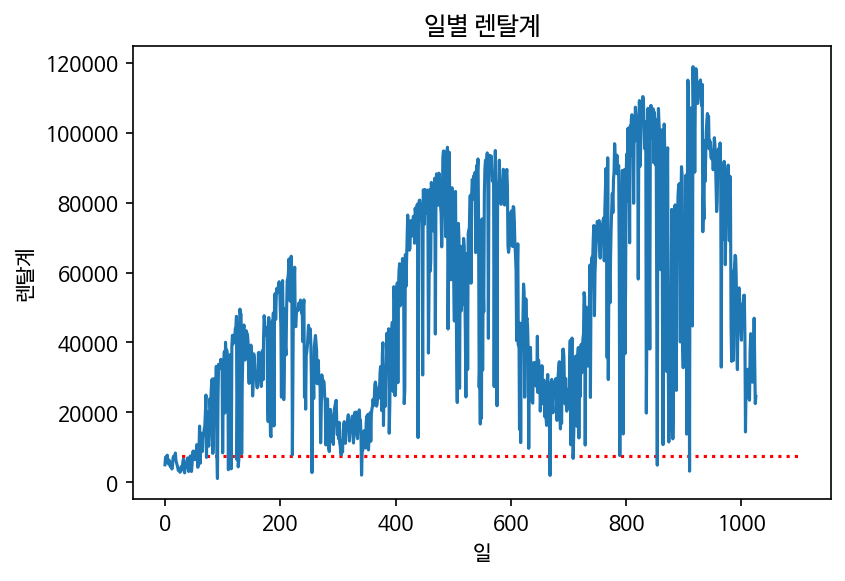

In [36]:
plt.figure(dpi=150)
plt.title('일별 렌탈계')
plt.xlabel('일')
plt.ylabel('렌탈계')


plt.plot(train.index, train['rental'])
# 렌탈계 이상치가 7500 미만인 날이라고 가정하자.
plt.hlines(y=7500, xmin=0, xmax=1100, color='red', linestyle='dotted')
plt.show()

In [37]:
train[train['rental'] < 7500].describe()

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.00000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,11.669231,0.564615,4.600000,-2.732308,38.815385,24.538462,57.90000,4.872308,47.540000,2.113846,4.567692,4968.969231,2018.138462,2.292308,13.415385
std,23.175869,9.569865,8.922531,10.259570,20.896989,16.091610,21.75691,3.884404,37.964748,0.936896,1.453993,1611.322642,0.496139,2.089580,8.640190
min,0.000000,-14.800000,-10.700000,-17.800000,8.000000,4.000000,26.90000,0.000000,0.000000,0.700000,1.700000,1037.000000,2018.000000,1.000000,1.000000
25%,0.000000,-5.800000,-1.200000,-9.600000,27.000000,14.000000,40.90000,0.000000,0.000000,1.400000,3.500000,3756.000000,2018.000000,1.000000,7.000000
50%,0.000000,-0.800000,4.000000,-5.200000,35.000000,19.000000,51.10000,5.600000,57.100000,1.900000,4.600000,4929.000000,2018.000000,2.000000,13.000000
75%,3.700000,4.200000,7.700000,1.800000,48.000000,32.000000,73.30000,8.700000,86.600000,2.700000,5.600000,6391.000000,2018.000000,2.000000,20.000000
max,83.500000,22.600000,26.900000,21.800000,99.000000,78.000000,97.00000,9.700000,90.700000,4.200000,8.000000,7477.000000,2020.000000,11.000000,31.000000


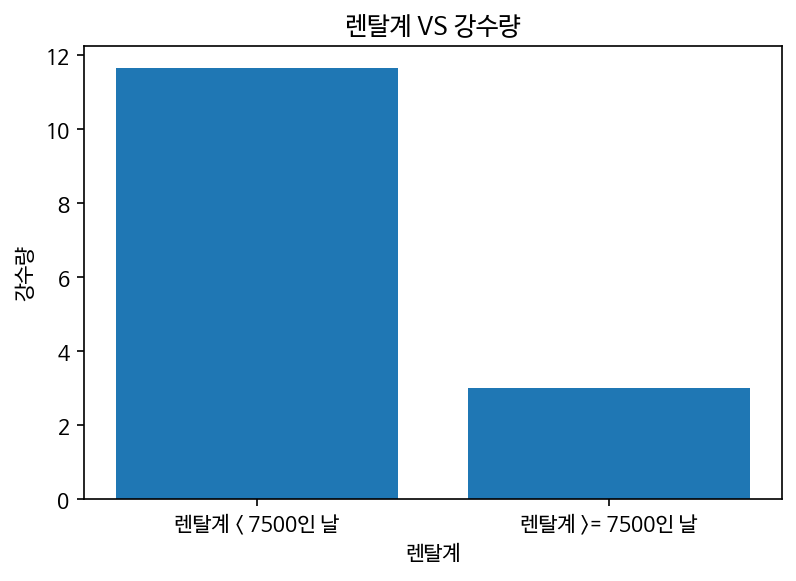

In [38]:
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['precipitation'].mean(),
     train[train['rental'] >= 7500]['precipitation'].mean()]

plt.figure(dpi=150)
plt.title('렌탈계 VS 강수량')
plt.xlabel('렌탈계')
plt.ylabel('강수량')

plt.bar(x,y)
plt.show()

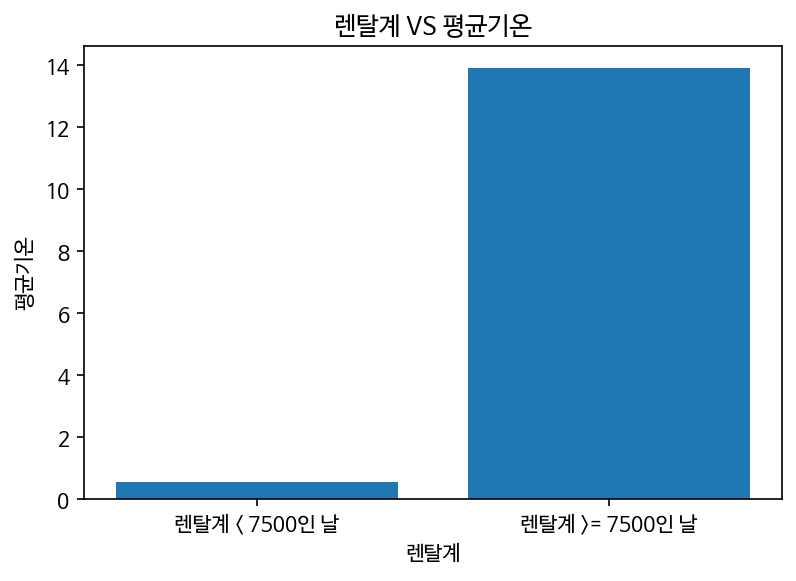

In [39]:
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['temp_mean'].mean(),
     train[train['rental'] >= 7500]['temp_mean'].mean()]

plt.figure(dpi=150)
plt.title('렌탈계 VS 평균기온')
plt.xlabel('렌탈계')
plt.ylabel('평균기온')

plt.bar(x,y)
plt.show()

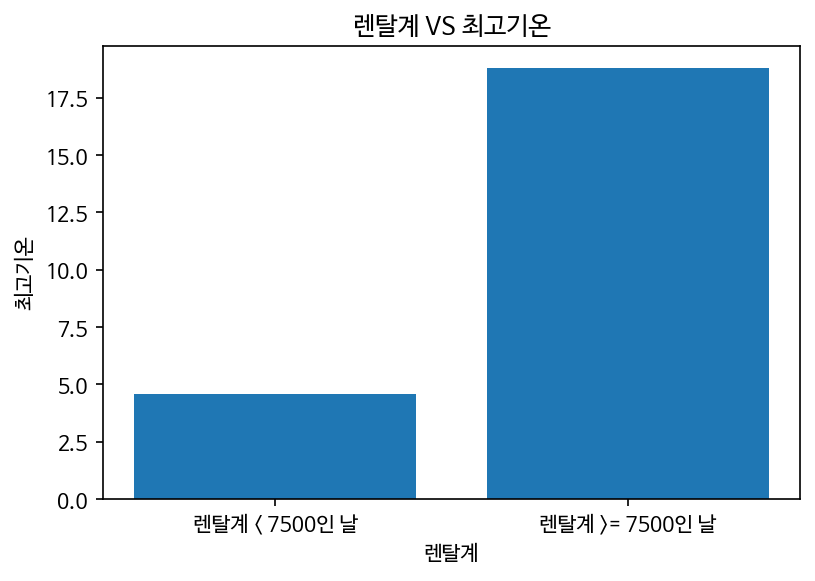

In [40]:
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['temp_highest'].mean(),
     train[train['rental'] >= 7500]['temp_highest'].mean()]

plt.figure(dpi=150)
plt.title('렌탈계 VS 최고기온')
plt.xlabel('렌탈계')
plt.ylabel('최고기온')

plt.bar(x,y)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


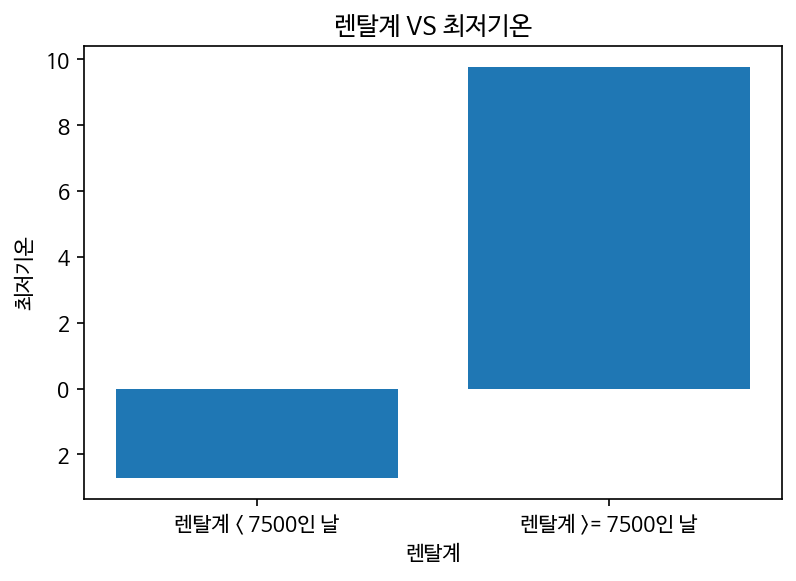

-2.732307692307693 9.775546305931323


In [41]:
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['temp_lowest'].mean(),
     train[train['rental'] >= 7500]['temp_lowest'].mean()]

plt.figure(dpi=150)
plt.title('렌탈계 VS 최저기온')
plt.xlabel('렌탈계')
plt.ylabel('최저기온')

plt.bar(x,y)
plt.show()

print(train[train['rental'] < 7500]['temp_lowest'].mean(), 
      train[train['rental'] >= 7500]['temp_lowest'].mean())

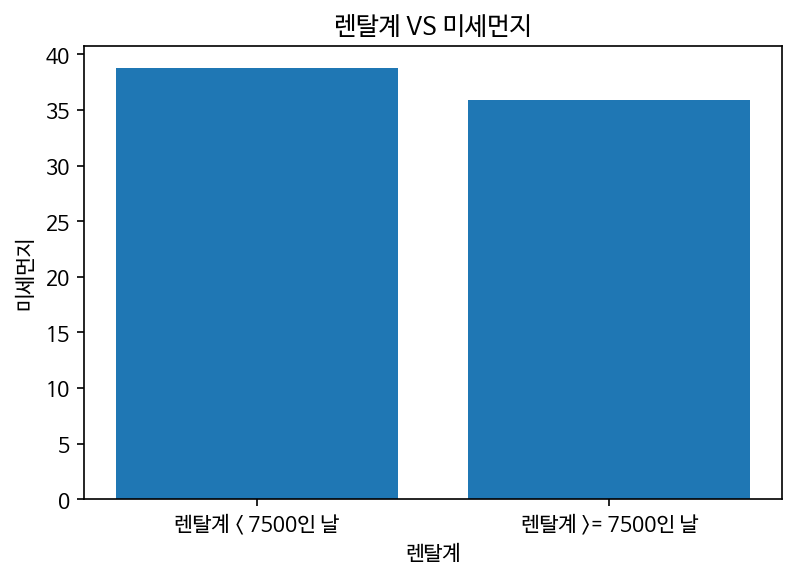

38.815384615384616 35.89594172736732


In [42]:
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['PM10'].mean(),
     train[train['rental'] >= 7500]['PM10'].mean()]

plt.figure(dpi=150)
plt.title('렌탈계 VS 미세먼지')
plt.xlabel('렌탈계')
plt.ylabel('미세먼지')

plt.bar(x,y)
plt.show()

print(train[train['rental'] < 7500]['PM10'].mean(), 
      train[train['rental'] >= 7500]['PM10'].mean())

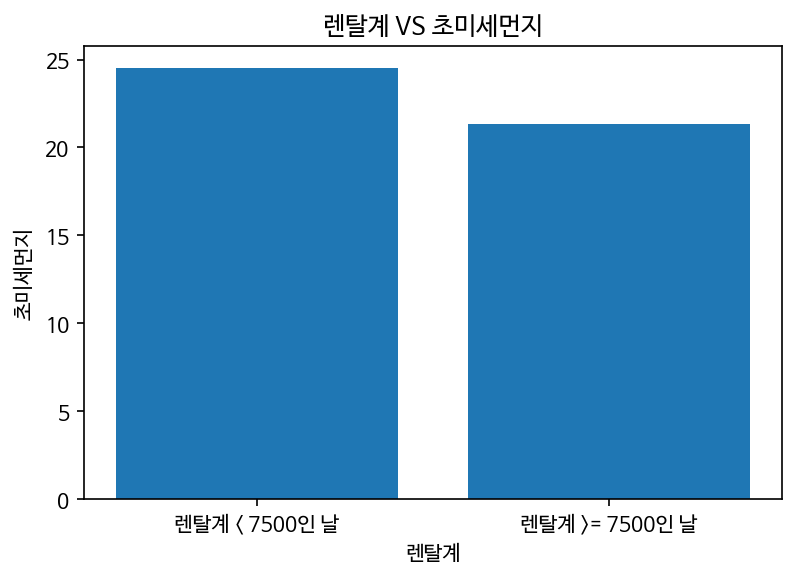

24.53846153846154 21.329864724245578


In [43]:
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['PM2.5'].mean(),
     train[train['rental'] >= 7500]['PM2.5'].mean()]

plt.figure(dpi=150)
plt.title('렌탈계 VS 초미세먼지')
plt.xlabel('렌탈계')
plt.ylabel('초미세먼지')

plt.bar(x,y)
plt.show()

print(train[train['rental'] < 7500]['PM2.5'].mean(), 
      train[train['rental'] >= 7500]['PM2.5'].mean())

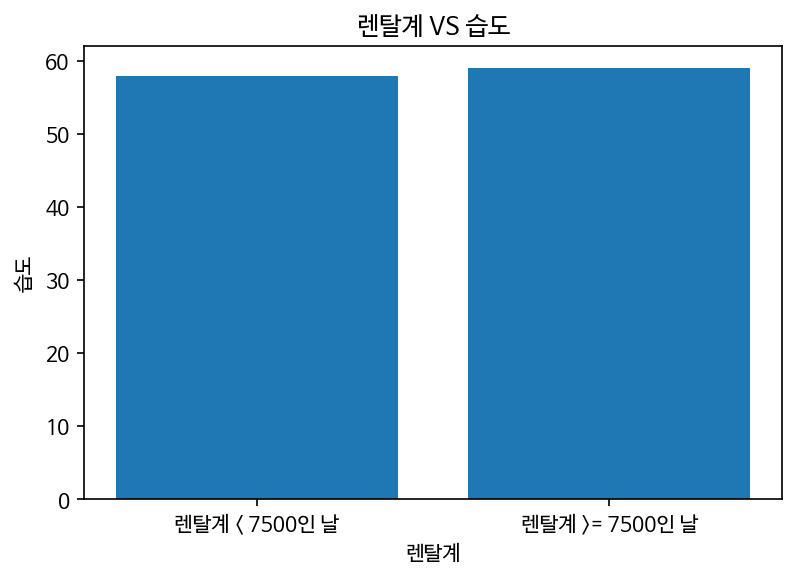

57.90000000000001 59.073569198751535


In [44]:
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['humidity'].mean(),
     train[train['rental'] >= 7500]['humidity'].mean()]

plt.figure(dpi=150)
plt.title('렌탈계 VS 습도')
plt.xlabel('렌탈계')
plt.ylabel('습도')

plt.bar(x,y)
plt.show()

print(train[train['rental'] < 7500]['humidity'].mean(), 
      train[train['rental'] >= 7500]['humidity'].mean())

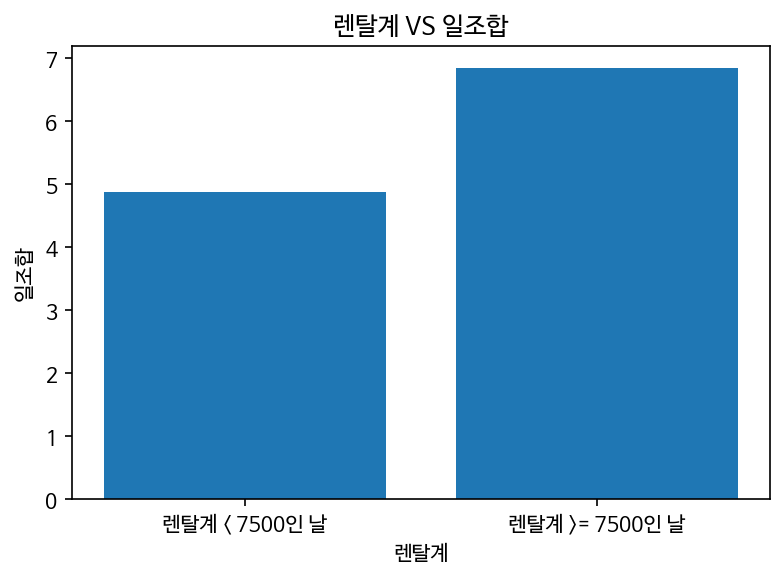

4.872307692307693 6.852653485952142


In [45]:
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['sunshine_sum'].mean(),
     train[train['rental'] >= 7500]['sunshine_sum'].mean()]

plt.figure(dpi=150)
plt.title('렌탈계 VS 일조합')
plt.xlabel('렌탈계')
plt.ylabel('일조합')

plt.bar(x,y)
plt.show()

print(train[train['rental'] < 7500]['sunshine_sum'].mean(), 
      train[train['rental'] >= 7500]['sunshine_sum'].mean())

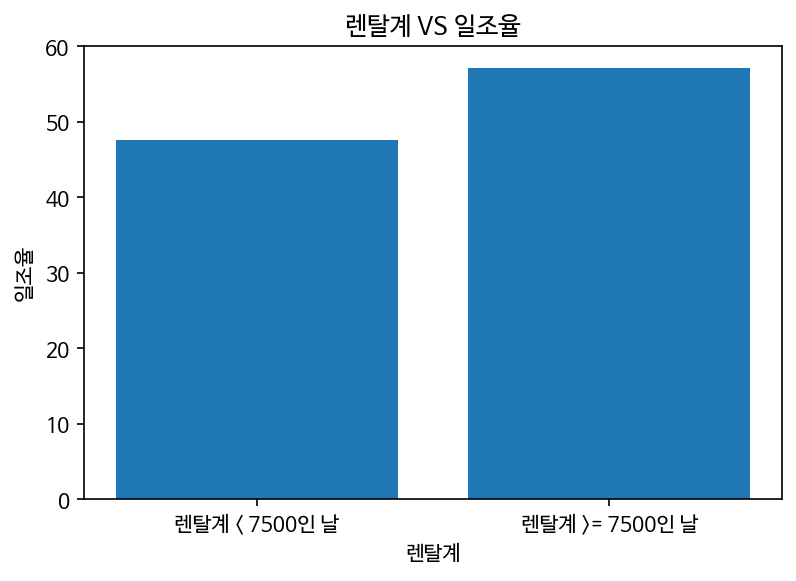

47.54 57.161810613943864


In [46]:
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['sunshine_rate'].mean(),
     train[train['rental'] >= 7500]['sunshine_rate'].mean()]

plt.figure(dpi=150)
plt.title('렌탈계 VS 일조율')
plt.xlabel('렌탈계')
plt.ylabel('일조율')

plt.bar(x,y)
plt.show()

print(train[train['rental'] < 7500]['sunshine_rate'].mean(), 
      train[train['rental'] >= 7500]['sunshine_rate'].mean())